In [1]:
import pandas as pd
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
# import umap
import json
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from sklearn.cluster import DBSCAN

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn import metrics

import plotly.graph_objs as go

import requests

In [2]:
def get_node_info(indexes, mappings):
    apis = 'https://glkb.dcmb.med.umich.edu/api'
    results = dict()
    
    inv_m = {v:k for k, v in mappings.items()}
    for i in indexes:
        nid = inv_m.get(i)
        if nid:
            response = requests.get(f"{apis}/nodes/entity/{nid}")
            if response.status_code == 200:
                node_info = response.json()
                results[i] = node_info
    return results

def get_node_embs(eids):
    apis = 'https://glkb.dcmb.med.umich.edu/api'

    dat = [{'element id': eid} for eid in eids]
    response = requests.post(f"{apis}/emb/batch_entity_embedding", json=dat)
    assert response.status_code == 200
    return response.json()

def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# visualize term embeddings

In [ ]:
node_emb = torch.load('/nfs/turbo/umms-drjieliu/proj/prompt_re/kg_embeddings/outputs/term_embeddings_binary.pk').detach().numpy() # /nfs/turbo/umms-drjieliu/proj/prompt_re/kg_embeddings/outputs/term_embeddings_binary.pk
node_index_mappings = json.load(open('/nfs/turbo/umms-drjieliu/proj/prompt_re/kg_embeddings/data/node_index_mappings.json'))
results = get_node_info(range(len(node_emb)), node_index_mappings)

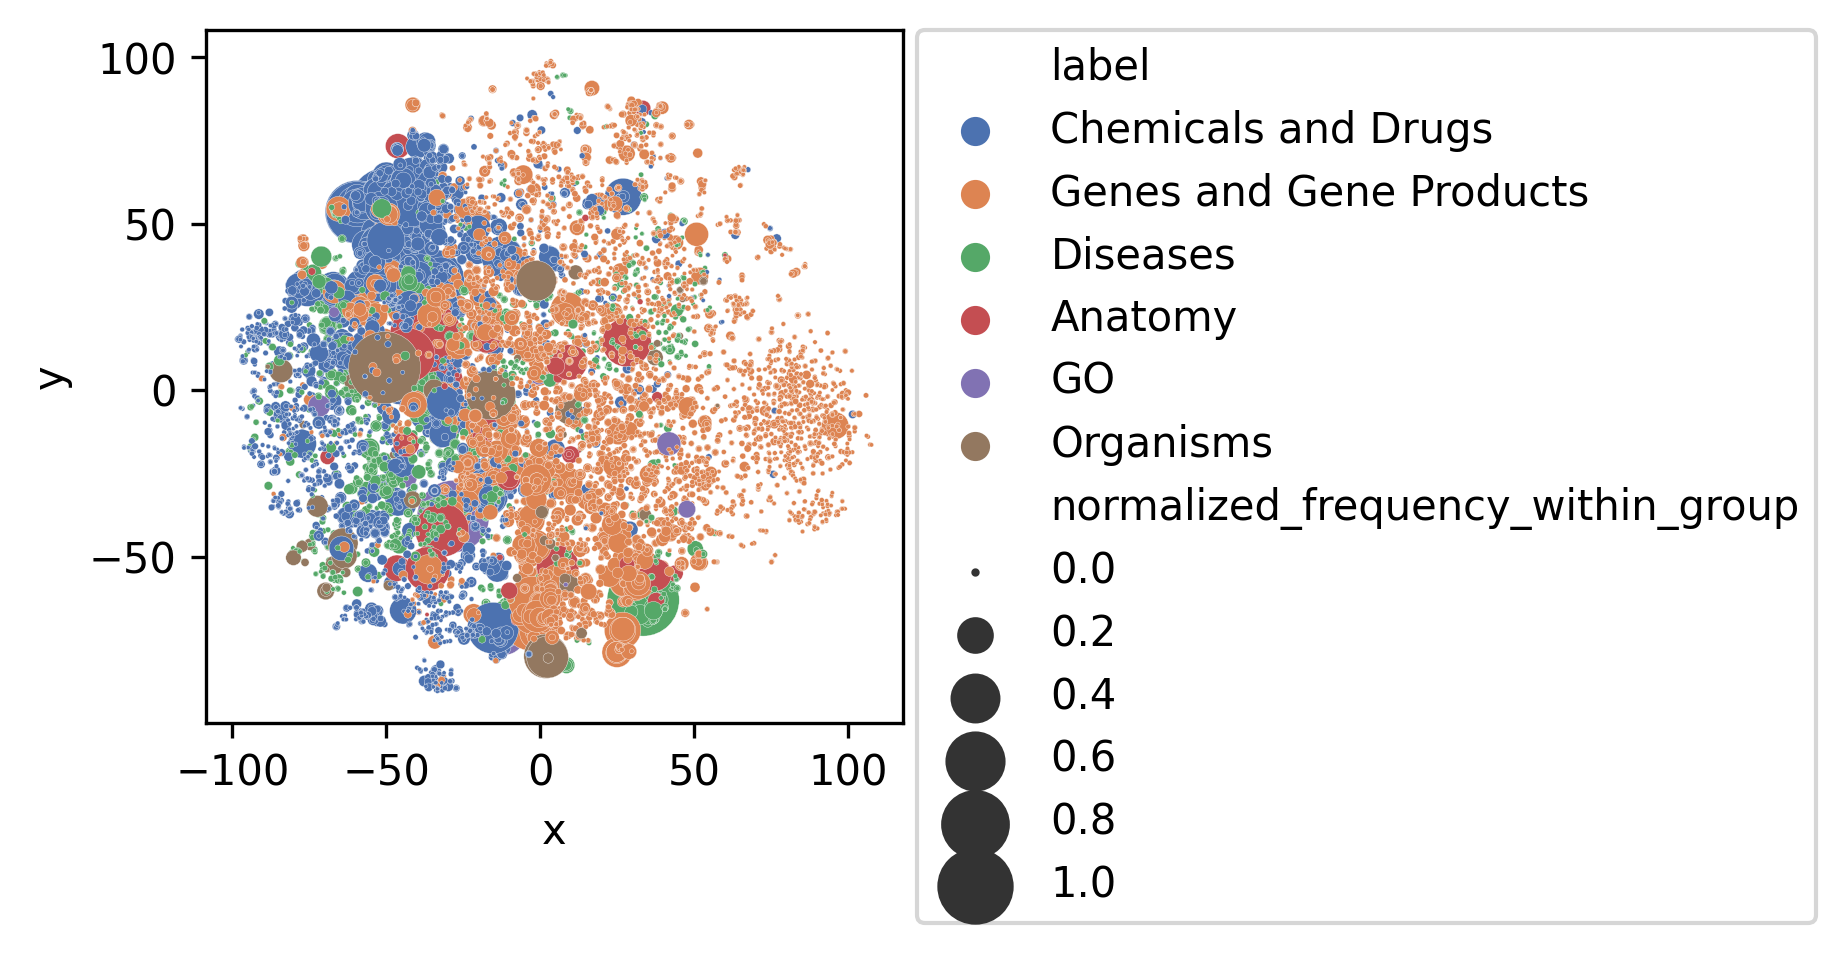

In [45]:


tsne = TSNE(n_components=2, perplexity=10)
emb = tsne.fit_transform(node_emb)

df = pd.DataFrame({
    'x': emb[:,0],
    'y': emb[:,1],
    'label': [results.get(i).get('type')[0] for i in range(len(emb))],
    'degrees': [results.get(i).get('n_citations') if results.get(i).get('n_citations') else 0 for i in range(len(emb))],
})
df['normalized_frequency_within_group'] = df.groupby('label')['degrees'].transform(normalize)
df.to_csv('data/hgt_emb_tsne.csv', index=None)
fig, ax = plt.subplots(figsize=(3,3), dpi = 300)
sns.scatterplot(data=df, x='x', y='y', hue='label', size='normalized_frequency_within_group', ax=ax, palette='deep', sizes=(1, 300))
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

# link prediction

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import f1_score

In [25]:
# split set
def split_data(dataset, labels, train_prop = 0.5, model_select_prop = 0.3):
    idx = list(range(len(dataset)))
    np.random.shuffle(idx)

    dataset = dataset[idx]
    labels = np.array(labels)[idx]

    train_set = dataset[:int(len(dataset)*train_prop)]
    train_lab = labels[:int(len(dataset)*train_prop)]
    model_select_set = dataset[int(len(dataset)*train_prop):int(len(dataset)*(train_prop+model_select_prop))]
    model_select_lab = labels[int(len(dataset)*train_prop):int(len(dataset)*(train_prop+model_select_prop))]
    test_set = dataset[int(len(dataset)*(train_prop+model_select_prop)):]
    test_lab = labels[int(len(dataset)*(train_prop+model_select_prop)):]
    return train_set, train_lab, model_select_set, model_select_lab, test_set, test_lab

# 1. link embeddings
def link_examples_to_features(link_examples, node_embedding, binary_operator):
    return [
        binary_operator(node_embedding[src], node_embedding[dst])
        for src, dst in link_examples
    ]


# 2. training classifier
def train_link_prediction_model(
    link_examples, link_labels, node_embedding, binary_operator
):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, node_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf


def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
    clf, link_examples_test, link_labels_test, node_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, node_embedding, binary_operator
    )
    scores = evaluate_roc_auc_f1(clf, link_features_test, link_labels_test)
    return scores


def evaluate_roc_auc_f1(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)
    predicted_lab = clf.predict(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column]), f1_score(link_labels, predicted_lab)

def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0


def run_link_prediction(train_set, train_lab, model_select_set, model_select_lab, binary_operator, node_emb):
    clf = train_link_prediction_model(
        train_set, train_lab, node_emb, binary_operator
    )
    scores = evaluate_link_prediction_model(
        clf,
        model_select_set,
        model_select_lab,
        node_emb,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "ROC AUC": scores[0],
        "f1": scores[1],
    }


binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

## predict gene regulation

In [33]:
## generate dataset
df = pd.read_csv('../example_data/relationship-gene2gene.csv').drop_duplicates()
embs = get_node_embs(pd.unique(pd.concat([df[':START_ID(VOCAB-ID)'], df[':END_ID(VOCAB-ID)']])))
node_emb = np.array(list(embs.values()))
node_idx = dict(zip(embs.keys(), range(len(embs))))

pos_data = pd.DataFrame({
    'start': df[':START_ID(VOCAB-ID)'].apply(node_idx.get),
    'end': df[':END_ID(VOCAB-ID)'].apply(node_idx.get)
})
pos_data = pos_data.dropna().astype(int).reset_index(drop=True)
pos_data_pool = np.array(list(set(pos_data['start']).union(set(pos_data['end']))))
neg_data = pd.DataFrame({'start': np.random.choice(pos_data_pool, len(pos_data)),
            'end': np.random.choice(pos_data_pool, len(pos_data))
            })
neg_data = neg_data[~((neg_data['start']==pos_data['start']) & (neg_data['end']==pos_data['end']))]

dataset = pd.concat([pos_data, neg_data]).to_numpy()
labels = np.array([1] * len(pos_data) + [0] * len(neg_data))

train_set, train_lab, model_select_set, model_select_lab, test_set, test_lab = split_data(dataset, labels, train_prop = 0.5, model_select_prop = 0.3)

dataset_df = pd.DataFrame(
    [
        (
            "Training Set",
            len(train_set),
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(model_select_set),
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(test_set),
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Use"),
).set_index("Split")
print(dataset_df)

                 Number of Examples                                    Use
Split                                                                     
Training Set                  72241              Train the Link Classifier
Model Selection               43344  Select the best Link Classifier model
Test set                      28897      Evaluate the best Link Classifier


In [50]:
## predict
results = [run_link_prediction(train_set, train_lab, model_select_set, model_select_lab, op, node_emb) for op in binary_operators]
best_result = max(results, key=lambda result: result['ROC AUC'])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

evaluate_df = pd.DataFrame(
    [(result["binary_operator"].__name__, result['ROC AUC'], result['f1']) for result in results],
    columns=("name", "ROC AUC score", "f1"),
).set_index("name")
print(evaluate_df)

Best result from 'operator_avg'
                   ROC AUC score        f1
name                                      
operator_hadamard       0.822270  0.753095
operator_l1             0.823693  0.750148
operator_l2             0.845435  0.774450
operator_avg            0.858911  0.782195


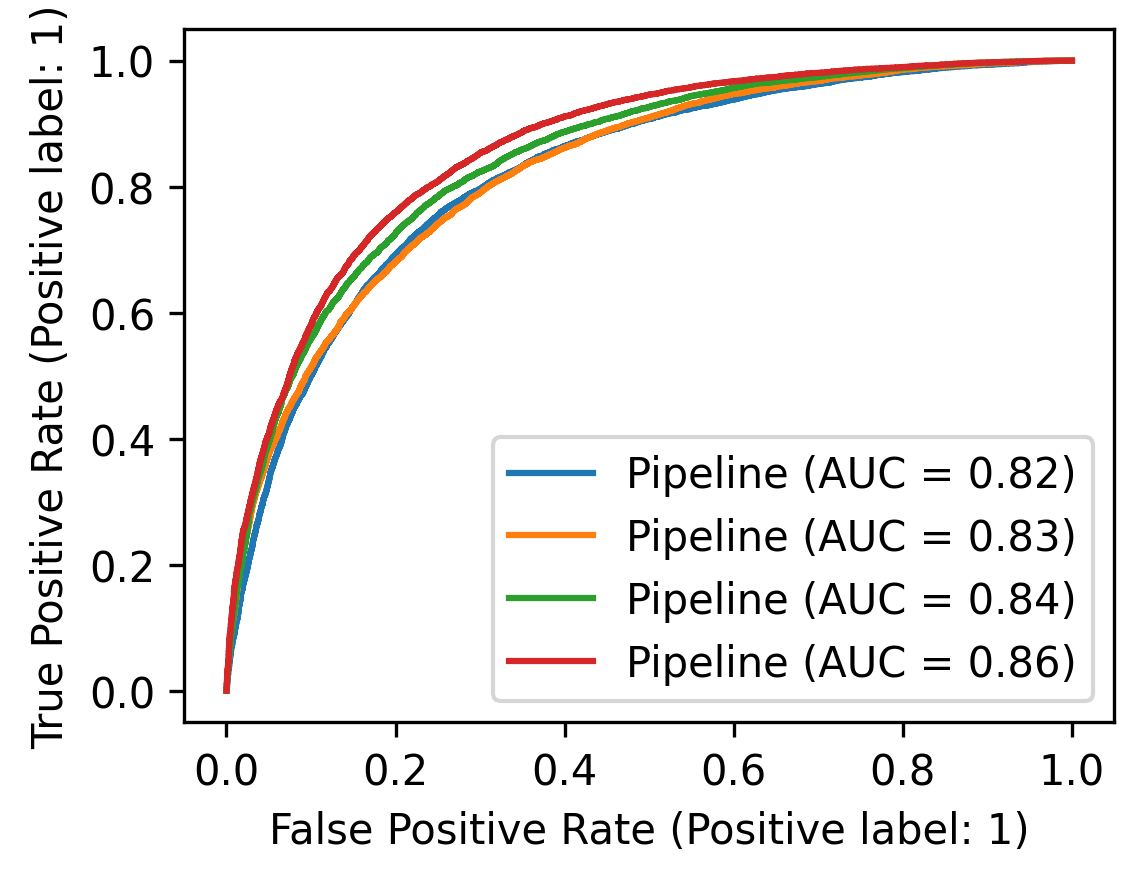

In [51]:
fig, ax = plt.subplots(figsize=(4,3), dpi = 300)

for i in range(len(results)):
    link_features_test = link_examples_to_features(
            test_set, node_emb, binary_operators[i]
        )
    metrics.RocCurveDisplay.from_estimator(results[i]['classifier'], link_features_test, test_lab, ax=ax)
plt.show()
# plt.savefig('figs/gene_reg.svg', format='svg')

## ligand-receptor binding

In [35]:
## generate dataset
df = pd.read_csv('../example_data/relationship-cellphonedb_gene2gene.csv')
embs = get_node_embs(pd.unique(pd.concat([df[':START_ID(VOCAB-ID)'], df[':END_ID(VOCAB-ID)']])))
node_emb = np.array(list(embs.values()))
node_idx = dict(zip(embs.keys(), range(len(embs))))
pos_data = pd.DataFrame({
    'start': df[':START_ID(VOCAB-ID)'].apply(node_idx.get),
    'end': df[':END_ID(VOCAB-ID)'].apply(node_idx.get)
})
pos_data = pos_data.dropna().astype(int).reset_index(drop=True)
candidates = np.unique(np.concatenate([pd.unique(pos_data['start']), pd.unique(pos_data['end'])]))
neg_data = pd.DataFrame(
    {
        'start': np.random.choice(candidates, len(pos_data)),
        'end': np.random.choice(candidates, len(pos_data)),
    }
)
neg_data = neg_data[~((neg_data['start']==pos_data['start']) & (neg_data['end']==pos_data['end']))]

dataset = pd.concat([pos_data, neg_data]).to_numpy()
labels = np.array([1] * len(pos_data) + [0] * len(neg_data))

train_set, train_lab, model_select_set, model_select_lab, test_set, test_lab = split_data(dataset, labels, train_prop = 0.5, model_select_prop = 0.3)

dataset_df = pd.DataFrame(
    [
        (
            "Training Set",
            len(train_set),
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(model_select_set),
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(test_set),
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Use"),
).set_index("Split")
print(dataset_df)

                 Number of Examples                                    Use
Split                                                                     
Training Set                    851              Train the Link Classifier
Model Selection                 510  Select the best Link Classifier model
Test set                        341      Evaluate the best Link Classifier


In [ ]:
## predict
results = [run_link_prediction(train_set, train_lab, model_select_set, model_select_lab, op, node_emb) for op in binary_operators]
best_result = max(results, key=lambda result: result['ROC AUC'])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

evaluate_df = pd.DataFrame(
    [(result["binary_operator"].__name__, result['ROC AUC'], result['f1']) for result in results],
    columns=("name", "ROC AUC score", "f1"),
).set_index("name")
print(evaluate_df)

In [15]:
target_terms = ['HGNC_2432', 'HGNC_6014']

clf = best_result['classifier']
candidates = np.unique(np.concatenate([pd.unique(df[':END_ID(VOCAB-ID)']), pd.unique(df[':START_ID(VOCAB-ID)'])]))
for target_term in target_terms:
    print(target_term)
    res = {}

    for t in candidates:
        if node_index_mappings.get(t):
            feat = link_examples_to_features([[node_index_mappings.get(target_term), node_index_mappings.get(t)]], node_emb, best_result['binary_operator'])
            res[t] = clf.predict_proba(feat)[0][1]

    order = sorted(res.keys(), key=lambda x: res[x], reverse=True)
    dbs = df[[':END_ID(VOCAB-ID)', ':START_ID(VOCAB-ID)']].apply(lambda x: set([x[':END_ID(VOCAB-ID)'], x[':START_ID(VOCAB-ID)']]), axis=1).drop_duplicates().to_list()

    print('rank\ttarget ligand\tpredicted receptor\tagreed with curated knowledge')
    for i, cad in enumerate(order[:5]):
        m = f'{i+1}\t{target_term}\t{cad}'
        validated = 'False'
        if set([target_term, cad]) in dbs:
            validated = 'True'
        print(f'{m}\t{validated}')

HGNC_2432
rank	target ligand	predicted receptor	agreed with curated knowledge
1	HGNC_2432	HGNC_2433	True
2	HGNC_2432	HGNC_11187	False
3	HGNC_2432	HGNC_6012	False
4	HGNC_2432	HGNC_8507	False
5	HGNC_2432	HGNC_6021	False
HGNC_6014
rank	target ligand	predicted receptor	agreed with curated knowledge
1	HGNC_6014	HGNC_6015	True
2	HGNC_6014	HGNC_2433	False
3	HGNC_6014	HGNC_1804	False
4	HGNC_6014	HGNC_6014	False
5	HGNC_6014	HGNC_6140	False


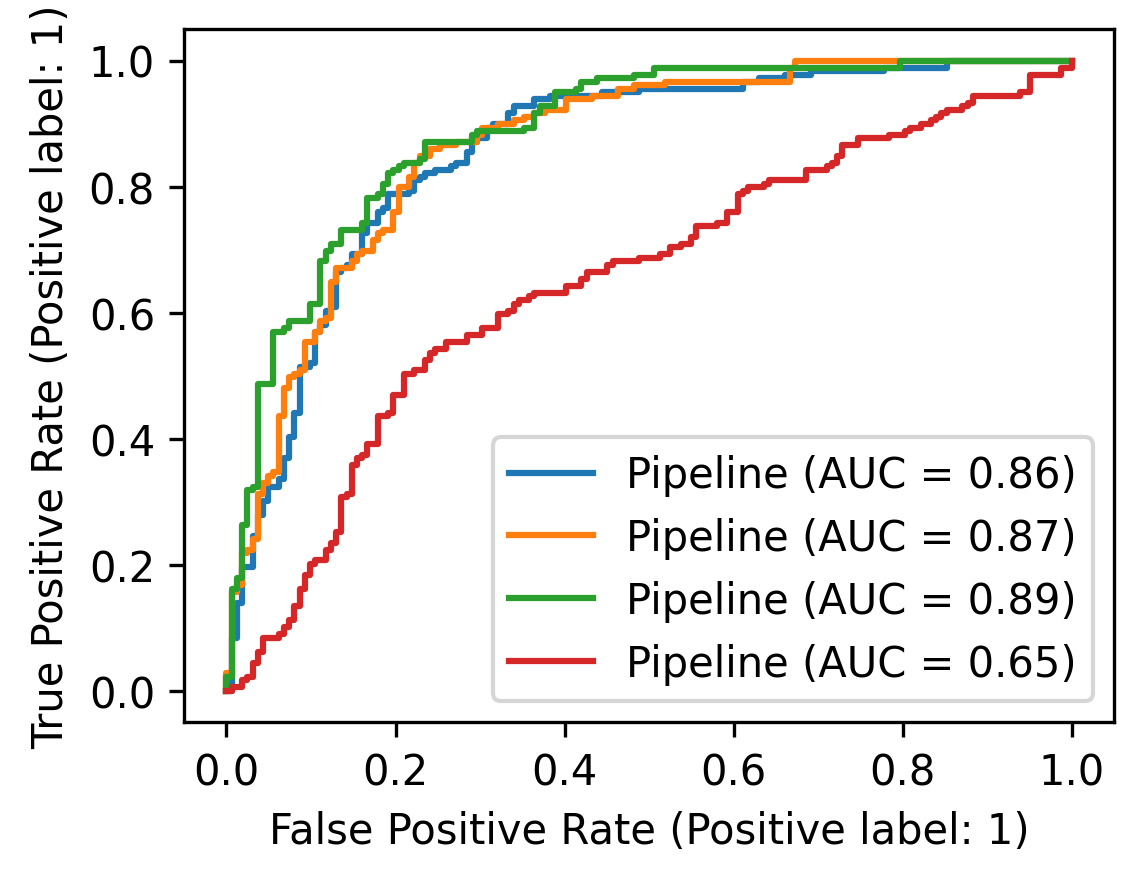

In [54]:
fig, ax = plt.subplots(figsize=(4,3), dpi = 300)

for i in range(len(results)):
    link_features_test = link_examples_to_features(
            test_set, node_emb, binary_operators[i]
        )
    metrics.RocCurveDisplay.from_estimator(results[i]['classifier'], link_features_test, test_lab, ax=ax)

plt.show()
# plt.savefig('figs/ligand-receptor.svg', format='svg')

## hierarchy

In [19]:
all_types = ['Anatomy', 'Genes and Gene Products', 'Chemicals and Drugs', 'Organisms', 'Diseases']
chosen_types = np.random.choice(range(len(all_types)), 3)
idx1 = np.array([id2source[id2source['label']==t]['id'].to_numpy() for t in all_types])

/tmp/ipykernel_10851/2283403749.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  idx1 = np.array([id2source[id2source['label']==t]['id'].to_numpy() for t in all_types])


In [38]:
## generate dataset
df = pd.read_csv('../example_data/relationship-gilda_hier.csv')
embs = get_node_embs(pd.unique(pd.concat([df[':START_ID(VOCAB-ID)'], df[':END_ID(VOCAB-ID)']])))
node_emb = np.array(list(embs.values()))
node_idx = dict(zip(embs.keys(), range(len(embs))))
pos_data = pd.DataFrame({
    'start': df[':START_ID(VOCAB-ID)'].apply(node_idx.get),
    'end': df[':END_ID(VOCAB-ID)'].apply(node_idx.get)
})
pos_data = pos_data.dropna().astype(int).reset_index(drop=True)
# generate negative data
chosen_types = np.random.choice(range(len(all_types)), len(pos_data))
neg_data = pd.DataFrame({'start': np.random.choice(pos_data['start'], len(pos_data)),
            'end': np.random.choice(pos_data['end'], len(pos_data))
            })
neg_data = neg_data[~((neg_data['start']==pos_data['start']) & (neg_data['end']==pos_data['end']))]

dataset = pd.concat([pos_data, neg_data]).to_numpy()
labels = np.array([1] * len(pos_data) + [0] * len(neg_data))

train_set, train_lab, model_select_set, model_select_lab, test_set, test_lab = split_data(dataset, labels, train_prop = 0.5, model_select_prop = 0.3)

dataset_df = pd.DataFrame(
    [
        (
            "Training Set",
            len(train_set),
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(model_select_set),
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(test_set),
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Use"),
).set_index("Split")
print(dataset_df)

AssertionError: 

In [21]:
## predict
results = [run_link_prediction(train_set, train_lab, model_select_set, model_select_lab, op) for op in binary_operators]
best_result = max(results, key=lambda result: result['ROC AUC'])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

evaluate_df = pd.DataFrame(
    [(result["binary_operator"].__name__, result['ROC AUC'], result['f1']) for result in results],
    columns=("name", "ROC AUC score", "f1"),
).set_index("name")
print(evaluate_df)

Best result from 'operator_hadamard'
                   ROC AUC score        f1
name                                      
operator_hadamard       0.903317  0.823219
operator_l1             0.875409  0.783478
operator_l2             0.880160  0.799323
operator_avg            0.489358  0.485314


In [26]:
target_terms = ['MESH_D014402']

clf = best_result['classifier']
candidates = np.unique(np.concatenate([pd.unique(df[':END_ID(VOCAB-ID)'])]))

for target_term in target_terms:
    print(target_term)
    res = {}

    for t in candidates:
        if node_index_mappings.get(t):
            feat = link_examples_to_features([[node_index_mappings.get(target_term), node_index_mappings.get(t)]], node_emb, best_result['binary_operator'])
            res[t] = clf.predict_proba(feat)[0][1]

    order = sorted(res.keys(), key=lambda x: res[x], reverse=True)
    dbs = df[[':END_ID(VOCAB-ID)', ':START_ID(VOCAB-ID)']].apply(lambda x: set([x[':END_ID(VOCAB-ID)'], x[':START_ID(VOCAB-ID)']]), axis=1).drop_duplicates().to_list()

    print('rank\ttarget ligand\tpredicted receptor\tagreed with curated knowledge')
    for i, cad in enumerate(order[:5]):
        m = f'{i+1}\t{target_term}\t{cad}'
        validated = 'False'
        if set([target_term, cad]) in dbs:
            validated = 'True'
        print(f'{m}\t{validated}')

MESH_D014402


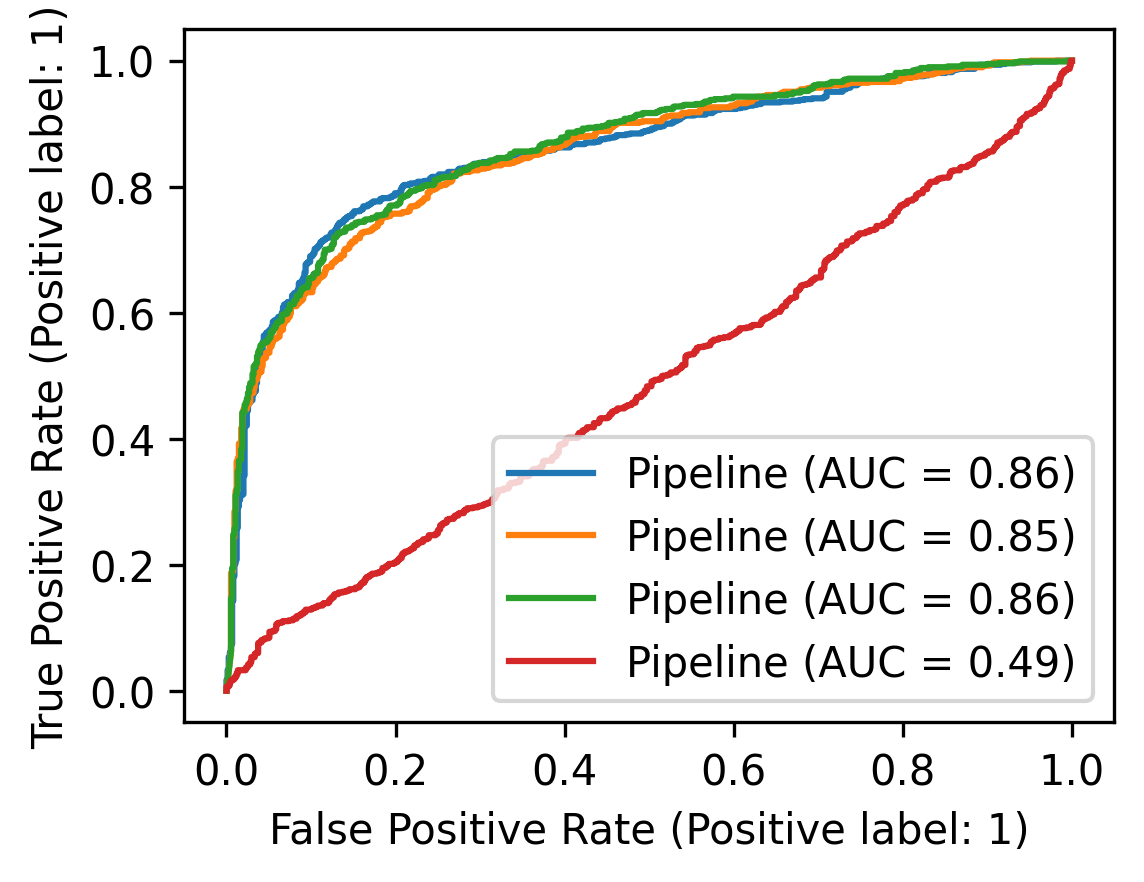

In [88]:
fig, ax = plt.subplots(figsize=(4,3), dpi = 300)

for i in range(len(results)):
    link_features_test = link_examples_to_features(
            test_set, node_emb, binary_operators[i]
        )
    metrics.RocCurveDisplay.from_estimator(results[i]['classifier'], link_features_test, test_lab, ax=ax)

plt.show()
# plt.savefig('figs/hier.svg', format='svg')

## GWAS

In [39]:
## generate dataset
df = pd.read_csv('../example_data/relationship-gwas_gene2trait.csv')
embs = get_node_embs(pd.unique(pd.concat([df[':START_ID(VOCAB-ID)'], df[':END_ID(VOCAB-ID)']])))
node_emb = np.array(list(embs.values()))
node_idx = dict(zip(embs.keys(), range(len(embs))))
pos_data = pd.DataFrame({
    'start': df[':START_ID(VOCAB-ID)'].apply(node_idx.get),
    'end': df[':END_ID(VOCAB-ID)'].apply(node_idx.get)
})
pos_data = pos_data.dropna().astype(int).reset_index(drop=True)

neg_data = pd.DataFrame(
    {
        'start': np.random.choice(pos_data['start'], len(pos_data)),
        'end': np.random.choice(pos_data['end'], len(pos_data)),
    }
)
neg_data = neg_data[~((neg_data['start']==pos_data['start']) & (neg_data['end']==pos_data['end']))]

dataset = pd.concat([pos_data, neg_data]).to_numpy()
labels = np.array([1] * len(pos_data) + [0] * len(neg_data))

train_set, train_lab, model_select_set, model_select_lab, test_set, test_lab = split_data(dataset, labels, train_prop = 0.5, model_select_prop = 0.3)

dataset_df = pd.DataFrame(
    [
        (
            "Training Set",
            len(train_set),
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(model_select_set),
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(test_set),
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Use"),
).set_index("Split")
print(dataset_df)

                 Number of Examples                                    Use
Split                                                                     
Training Set                   8328              Train the Link Classifier
Model Selection                4996  Select the best Link Classifier model
Test set                       3332      Evaluate the best Link Classifier


In [90]:
## predict
results = [run_link_prediction(train_set, train_lab, model_select_set, model_select_lab, op) for op in binary_operators]
best_result = max(results, key=lambda result: result['ROC AUC'])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

evaluate_df = pd.DataFrame(
    [(result["binary_operator"].__name__, result['ROC AUC'], result['f1']) for result in results],
    columns=("name", "ROC AUC score", "f1"),
).set_index("name")
print(evaluate_df)

Best result from 'operator_hadamard'
                   ROC AUC score        f1
name                                      
operator_hadamard       0.631844  0.571846
operator_l1             0.626362  0.580512
operator_l2             0.627217  0.588566
operator_avg            0.486237  0.425300


In [ ]:
target_terms = ['HGNC_11641']

clf = best_result['classifier']
candidates = np.unique(np.concatenate([pd.unique(df[':END_ID(VOCAB-ID)'])]))
for target_term in target_terms:
    print(target_term)
    res = {}

    for t in candidates:
        if node_index_mappings.get(t):
            feat = link_examples_to_features([[node_index_mappings.get(target_term), node_index_mappings.get(t)]], node_emb, best_result['binary_operator'])
            res[t] = clf.predict_proba(feat)[0][1]

    order = sorted(res.keys(), key=lambda x: res[x], reverse=True)
    dbs = df[[':END_ID(VOCAB-ID)', ':START_ID(VOCAB-ID)']].apply(lambda x: set([x[':END_ID(VOCAB-ID)'], x[':START_ID(VOCAB-ID)']]), axis=1).drop_duplicates().to_list()

    for i, cad in enumerate(order[:10]):
        print(i, target_term, cad)
        if set([target_term, cad]) in dbs:
            print(i)

HGNC_11641
0 HGNC_11641 MESH_D007333
1 HGNC_11641 MESH_D000071698
2 HGNC_11641 MESH_D024821
2
3 HGNC_11641 MESH_D003924
3
4 HGNC_11641 MESH_D009765
4
5 HGNC_11641 MESH_D015228
6 HGNC_11641 MESH_D011085
7 HGNC_11641 MESH_D065626
8 HGNC_11641 MESH_D003930
9 HGNC_11641 MESH_D003920
9
HGNC_3575
0 HGNC_3575 MESH_D015228
1 HGNC_3575 MESH_D000071698
2 HGNC_3575 MESH_D024821
2
3 HGNC_3575 DOID_423
4 HGNC_3575 MESH_D008105
5 HGNC_3575 DOID_0060190
6 HGNC_3575 MESH_D065626
7 HGNC_3575 MESH_D008103
8 HGNC_3575 MESH_D011695
9 HGNC_3575 MESH_D007333


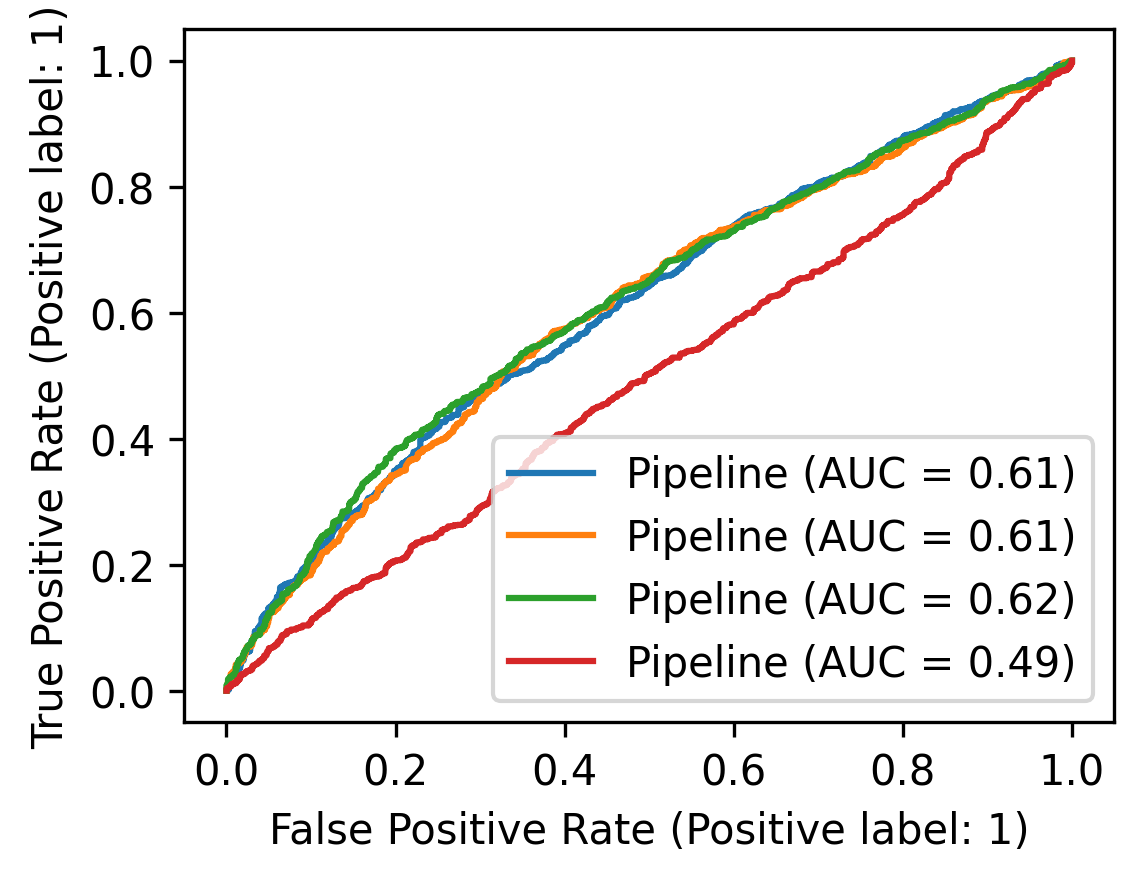

In [92]:
fig, ax = plt.subplots(figsize=(4,3), dpi = 300)

for i in range(len(results)):
    link_features_test = link_examples_to_features(
            test_set, node_emb, binary_operators[i]
        )
    metrics.RocCurveDisplay.from_estimator(results[i]['classifier'], link_features_test, test_lab, ax=ax)

plt.show()
# plt.savefig('figs/gwas.svg', format='svg')

## phen to gene

In [40]:
## generate dataset
df = pd.read_csv('../example_data/relationship-gilda_phen2gene.csv')
embs = get_node_embs(pd.unique(pd.concat([df[':START_ID(VOCAB-ID)'], df[':END_ID(VOCAB-ID)']])))
node_emb = np.array(list(embs.values()))
node_idx = dict(zip(embs.keys(), range(len(embs))))
pos_data = pd.DataFrame({
    'start': df[':START_ID(VOCAB-ID)'].apply(node_idx.get),
    'end': df[':END_ID(VOCAB-ID)'].apply(node_idx.get)
})
pos_data = pos_data.dropna().astype(int).reset_index(drop=True)

neg_data = pd.DataFrame({'start': np.random.choice(pos_data['start'], len(pos_data)),
            'end': np.random.choice(pos_data['end'], len(pos_data))
            })
neg_data = neg_data[~((neg_data['start']==pos_data['start']) & (neg_data['end']==pos_data['end']))]

dataset = pd.concat([pos_data, neg_data]).to_numpy()
labels = np.array([1] * len(pos_data) + [0] * len(neg_data))

train_set, train_lab, model_select_set, model_select_lab, test_set, test_lab = split_data(dataset, labels, train_prop = 0.5, model_select_prop = 0.3)

dataset_df = pd.DataFrame(
    [
        (
            "Training Set",
            len(train_set),
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(model_select_set),
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(test_set),
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Use"),
).set_index("Split")
print(dataset_df)

                 Number of Examples                                    Use
Split                                                                     
Training Set                  29961              Train the Link Classifier
Model Selection               17976  Select the best Link Classifier model
Test set                      11985      Evaluate the best Link Classifier


In [97]:
## predict
results = [run_link_prediction(train_set, train_lab, model_select_set, model_select_lab, op) for op in binary_operators]
best_result = max(results, key=lambda result: result['ROC AUC'])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

evaluate_df = pd.DataFrame(
    [(result["binary_operator"].__name__, result['ROC AUC'], result['f1']) for result in results],
    columns=("name", "ROC AUC score", "f1"),
).set_index("name")
print(evaluate_df)

Best result from 'operator_hadamard'
                   ROC AUC score        f1
name                                      
operator_hadamard       0.600278  0.555127
operator_l1             0.591296  0.569803
operator_l2             0.594429  0.578347
operator_avg            0.494166  0.521332


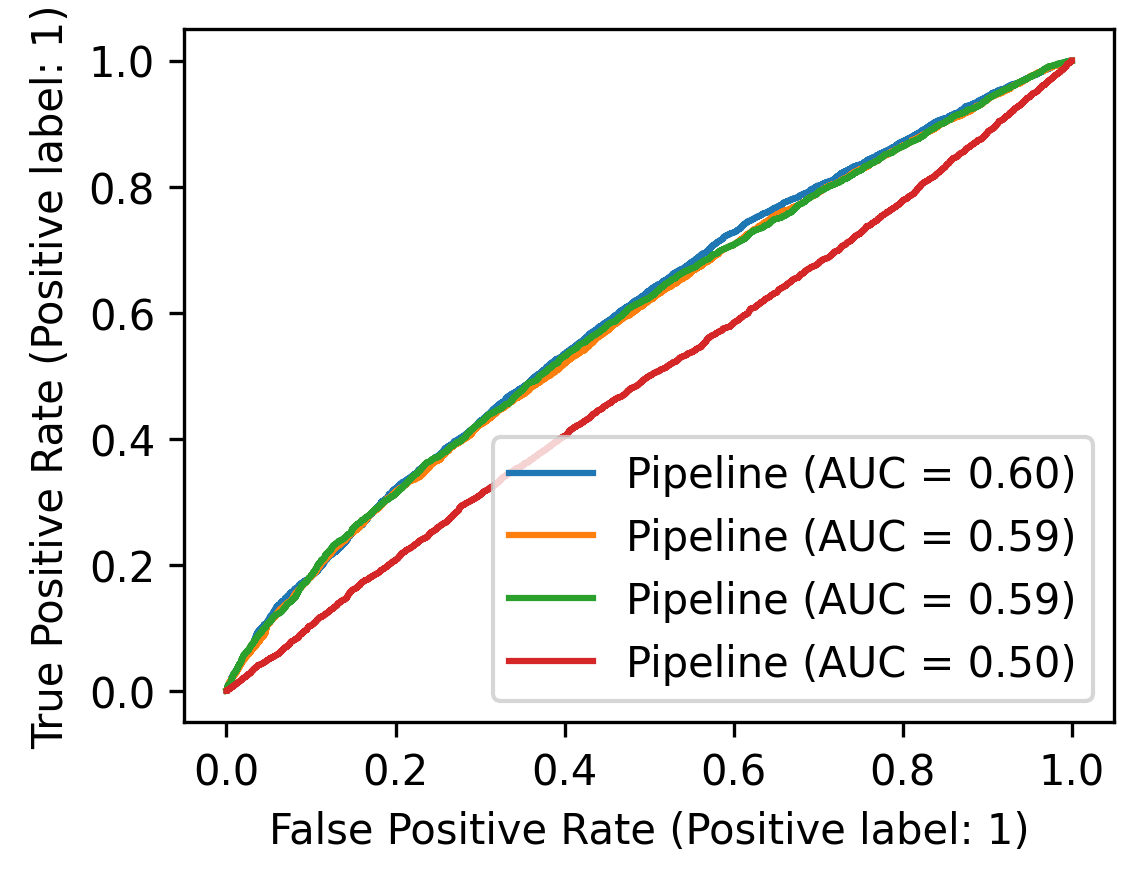

In [98]:
fig, ax = plt.subplots(figsize=(4,3), dpi = 300)

for i in range(len(results)):
    link_features_test = link_examples_to_features(
            test_set, node_emb, binary_operators[i]
        )
    metrics.RocCurveDisplay.from_estimator(results[i]['classifier'], link_features_test, test_lab, ax=ax)

plt.show()
# plt.savefig('figs/hpo.svg', format='svg')